In [3]:
import umap
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
import pandas as pd
import ast
import textwrap
import pyreadr

In [4]:
df_papers = pd.read_csv('../1_data/selected_papers_normalized.csv')
df_papers['embeddings'] = df_papers['embeddings'].apply(lambda x: ast.literal_eval(x))
df_papers['embeddings_normalized'] = df_papers['embeddings_normalized'].apply(lambda x: ast.literal_eval(x))
df_papers["papers"] = 1
df_papers.head(2)

,ID,Title,Source title,Abstract,Author Keywords,selected,human_labeled,selected_llm,text,embeddings,prediction,normalized,embeddings_normalized,papers
0,40296,Adam Smith’s Theory of Prudence Updated with N...,Neuroethics,"Other-perspective taking (OPT), distancing, ti...",Distancing; Episodic future thinking; Loss ave...,yes,1.0,yes,Title: Adam Smith’s Theory of Prudence Updated...,"[-0.05494213104248047, -0.24082590639591217, 0...",NaN,loss aversion in decision-making under risk a...,"[0.10613807290792465, 1.0692826509475708, -0.1...",1
1,18690,The effects of personal experience on choice-b...,International Journal of Wildland Fire,"In this paper, we investigate homeowner prefer...",expected utility; heuristics; natural disaster...,yes,1.0,yes,Title: The effects of personal experience on c...,"[0.09921591728925705, 0.5046013593673706, -0.0...",NaN,expected monetary losses from wildfires.,"[-0.24516017735004425, 1.2408509254455566, -0....",1


In [5]:
result = pyreadr.read_r('../1_data/loss_semantics_groups_97.RDS')

df_exp = result[None]

# Verificar si el objeto es un DataFrame de pandas
if isinstance(df_exp, pd.DataFrame):
    print("Read correctly")
else:
    print("An error ocurred")

df_exp.head(2)

Read correctly


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
group_1,0.053784,-0.398086,0.189684,-0.065552,-0.400603,-1.134082,0.149361,-0.019270,0.392275,0.421264,...,0.213889,-0.440790,0.146453,-0.197500,0.223208,0.795179,-0.227430,-0.020884,-0.551011,-0.192486
group_2,-0.839146,0.085717,-0.388971,0.062351,-0.822759,-0.958458,-0.047095,0.393427,-0.214224,0.626592,...,0.619314,-0.773316,-0.285683,-0.410959,0.358570,0.114703,0.108639,-0.202357,0.051336,-0.507607


In [6]:
# merge all columns in a list
df_exp['embeddings_normalized'] = df_exp.apply(lambda row: row.tolist(), axis=1)
df_exp = df_exp[['embeddings_normalized']]
df_exp.reset_index(inplace=True)
df_exp.rename(columns={'index': 'text'}, inplace=True)
df_exp["papers"] = 0
df_exp.head(2)

C:\Users\carer\AppData\Local\Temp\ipykernel_4072\799137909.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp.rename(columns={'index': 'text'}, inplace=True)
C:\Users\carer\AppData\Local\Temp\ipykernel_4072\799137909.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp["papers"] = 0


,text,embeddings_normalized,papers
0,group_1,"[0.053784485332733764, -0.39808553614183867, 0...",0
1,group_2,"[-0.8391460530692711, 0.08571678126463667, -0....",0


c:\Users\carer\Anaconda3\envs\loss_semantics\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


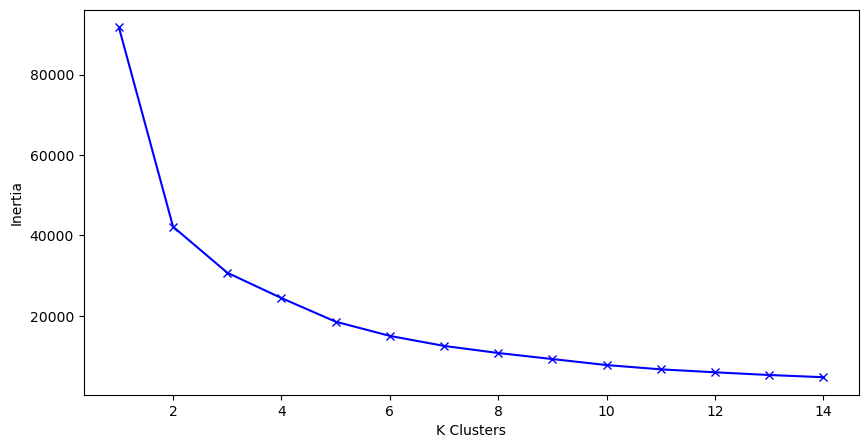

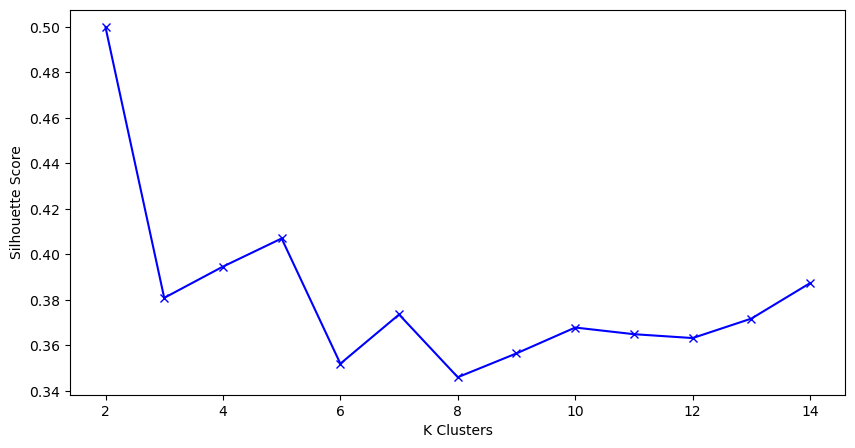

In [9]:
df = pd.concat([df_exp[['text', 'embeddings_normalized', 'papers']], df_papers[['text', 'embeddings_normalized', 'papers']]], ignore_index=True)

# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
df_reduced = reducer.fit_transform(df["embeddings_normalized"].tolist())

# Elbow Method
linkage_matrix = linkage(df_reduced, method='ward')
inertia = []
K = range(1, 15)
for k in K:
    clusters = fcluster(linkage_matrix, k, criterion='maxclust')
    inertia.append(np.sum([np.sum((df_reduced[clusters == c] - np.mean(df_reduced[clusters == c], axis=0))**2) for c in np.unique(clusters)]))

plt.figure(figsize=(10, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('K Clusters')
plt.ylabel('Inertia')
plt.show()

# Silhouette Method
silhouette_scores = []
K = range(2, 15)
for k in K:
    clusters = fcluster(linkage_matrix, k, criterion='maxclust')
    silhouette_scores.append(silhouette_score(df_reduced, clusters))

plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('K Clusters')
plt.ylabel('Silhouette Score')
plt.show()

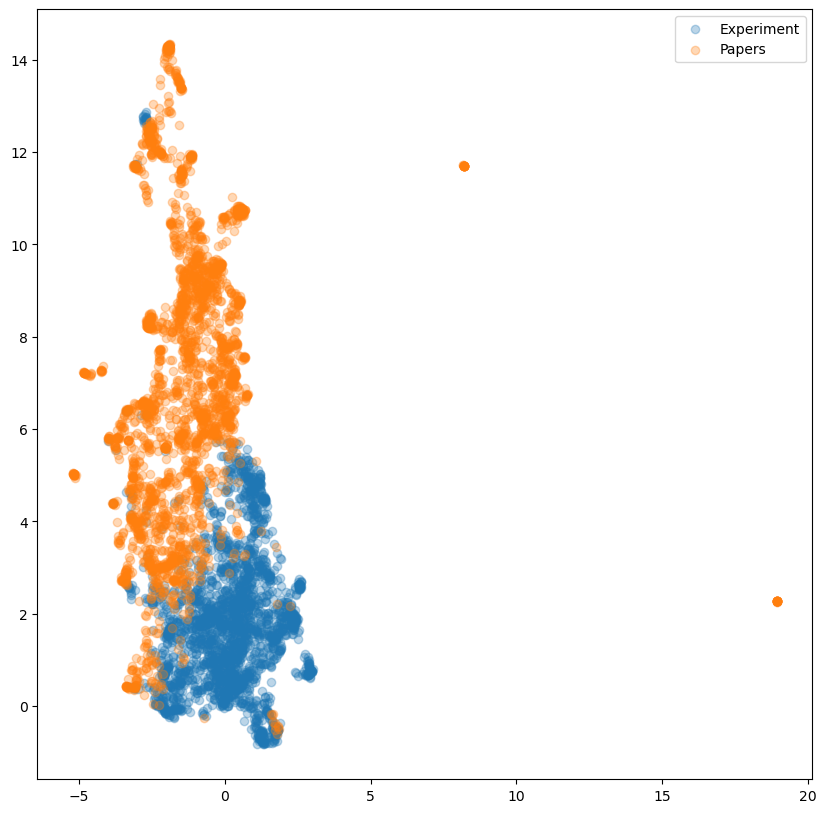

In [10]:
plt.figure(figsize=(10, 10))
plt.scatter(df_reduced[df['papers'] == 0, 0], df_reduced[df['papers'] == 0, 1], label='Experiment', alpha=0.3)
plt.scatter(df_reduced[df['papers'] == 1, 0], df_reduced[df['papers'] == 1, 1], label='Papers', alpha=0.3)
plt.legend()
plt.show()

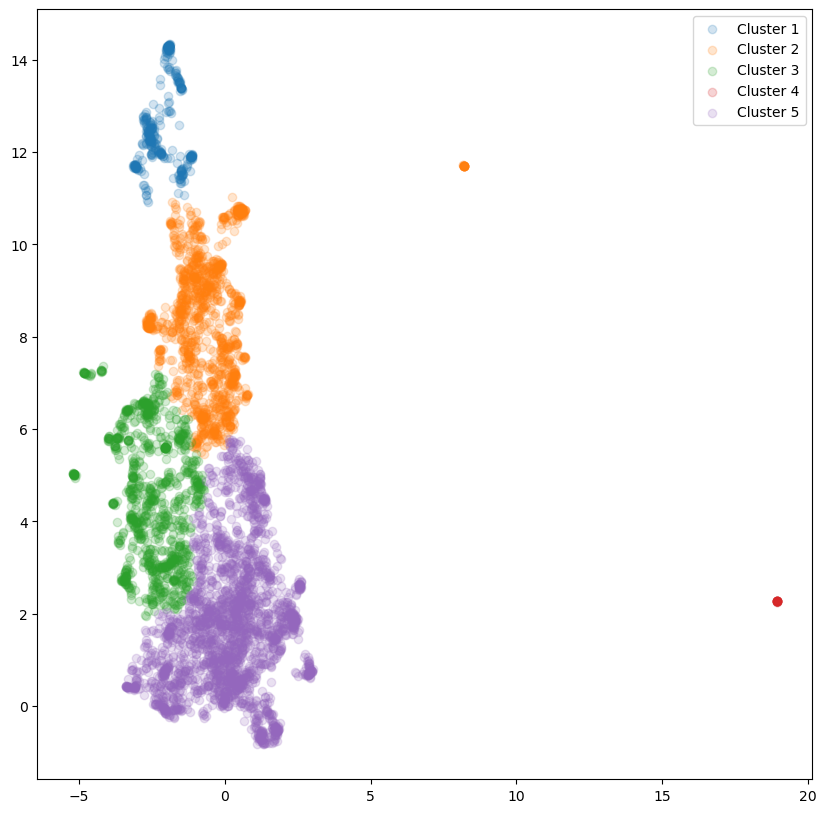

In [11]:
# Clustering
k = 5
clusters = fcluster(linkage_matrix, k, criterion='maxclust')
df['cluster'] = clusters

# Plot
plt.figure(figsize=(10, 10))
for i in range(k):
    plt.scatter(df_reduced[clusters == i+1, 0], df_reduced[clusters == i+1, 1], label=f'Cluster {i+1}', alpha=0.2)
plt.legend()
plt.show()

In [35]:
# Get 5 random examples from each cluster using textwrap
for i in range(k):
    print(f'Cluster {i+1}')
    for idx in df[df['cluster'] == i+1].sample(5).index:
        print(textwrap.fill(df.loc[idx, 'normalized'], width=200), "\n")
    print("\n\n\n")

Cluster 1
 Non-competitive losses in a simulated competition setting were analyzed and discussed. 

 Monetary losses in a simulated gambling task. 

 Monetary losses in a simulated gambling task. 

 Losses: Financial losses in lottery pairs and risk-value tradeoffs. 

 Financial losses in gambles with incomplete information. 





Cluster 2
 Financial losses and gains in decision-making under risk and uncertainty. 

 Financial losses due to ambiguity and uncertainty in insurance decision-making. 

 Losses were used as a decision-making factor in a heuristic model. 

 Probable losses in resource allocation tasks. 

 Expected losses across a series of decisions with stochastic payoffs. 





Cluster 3
 No losses mentioned in the paper. 

 No specific losses mentioned. 

 No specific losses mentioned in the article. 

 No specific losses mentioned in the paper. 

 No specific losses mentioned in the paper. 





Cluster 4
*Losses:* Contingent valuation approach estimates losses associated